# Data Science Project - Predicting Insurance Via Linear Regression

## Introduction
---
From a data set that compiles information on peoples' medical history we implement a linear regression model that attempts to predict the insurance costs of patients.


**Data Set Description ([source](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download))**

- `age`: age of primary beneficiary
- `sex`: insurance contractor gender, female, male
- `bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
- `objective` index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- `children`: Number of children covered by health insurance / Number of dependents
- `smoker`: Smoking
- `region`: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- `charges`: Individual medical costs billed by health insurance


In [48]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2 
from sklearn.model_selection import train_test_split as split
import statsmodels.api as sm

## Exploring The Data Set And Data Transformation

In [49]:
ins = pd.read_csv('insurance.csv')

ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [50]:
ins.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Convert `sex` and `smoker` into dummy variables.

For `sex`:
- `0` if `female`
- `1` if male

For `smoker`:
- `0` if no
- `1` if yes

In [51]:
ins['sex'] = ins['sex'].apply(lambda x: 0 if x=='female' else 1)

ins['smoker'] = ins['smoker'].apply(lambda x: 0 if x=='no' else 1)

### Correlations between the independent variables and the target.

In [53]:
ins.corr(numeric_only=True)['charges'].sort_values(ascending=False).round(2)[1:]*100

smoker      79.0
age         30.0
bmi         20.0
children     7.0
sex          6.0
Name: charges, dtype: float64

Has we can see, being a smoker seems to be highly positively correlated with `charges` (79%). The correlations between `charges` and `age` (30%), and between `charges` and `bmi` (20%) are also substantial, while the correlations of the target variable with `children` and `sex` are small (7% and 6%, respectively). 


#### Correlation Heat Map: visually exploring correlations between independent variables:

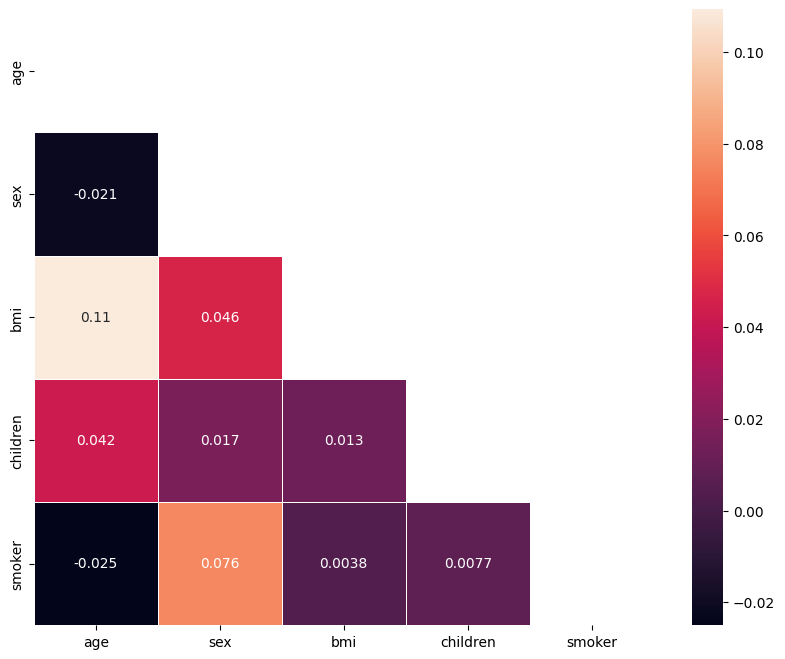

In [54]:
feats = [i for i in ins if i != 'charges']

corr = ins[feats].corr(method='pearson', numeric_only=True)

# Draw a heatmap with the numeric values in each cell.
f, ax = plt.subplots(figsize=(10, 8))

# Getting the Upper Triangle of the co-relation matrix.
matrix = np.triu(corr)

sns.heatmap(corr,
            annot=True,
            linewidths=.5,
            mask=matrix,
            ax=ax)

plt.show()

As we can see, there are no substantial correlations, positive or negative, between independent variables, i.e. multi-collinearity is not present.

### Scatter plot analysis

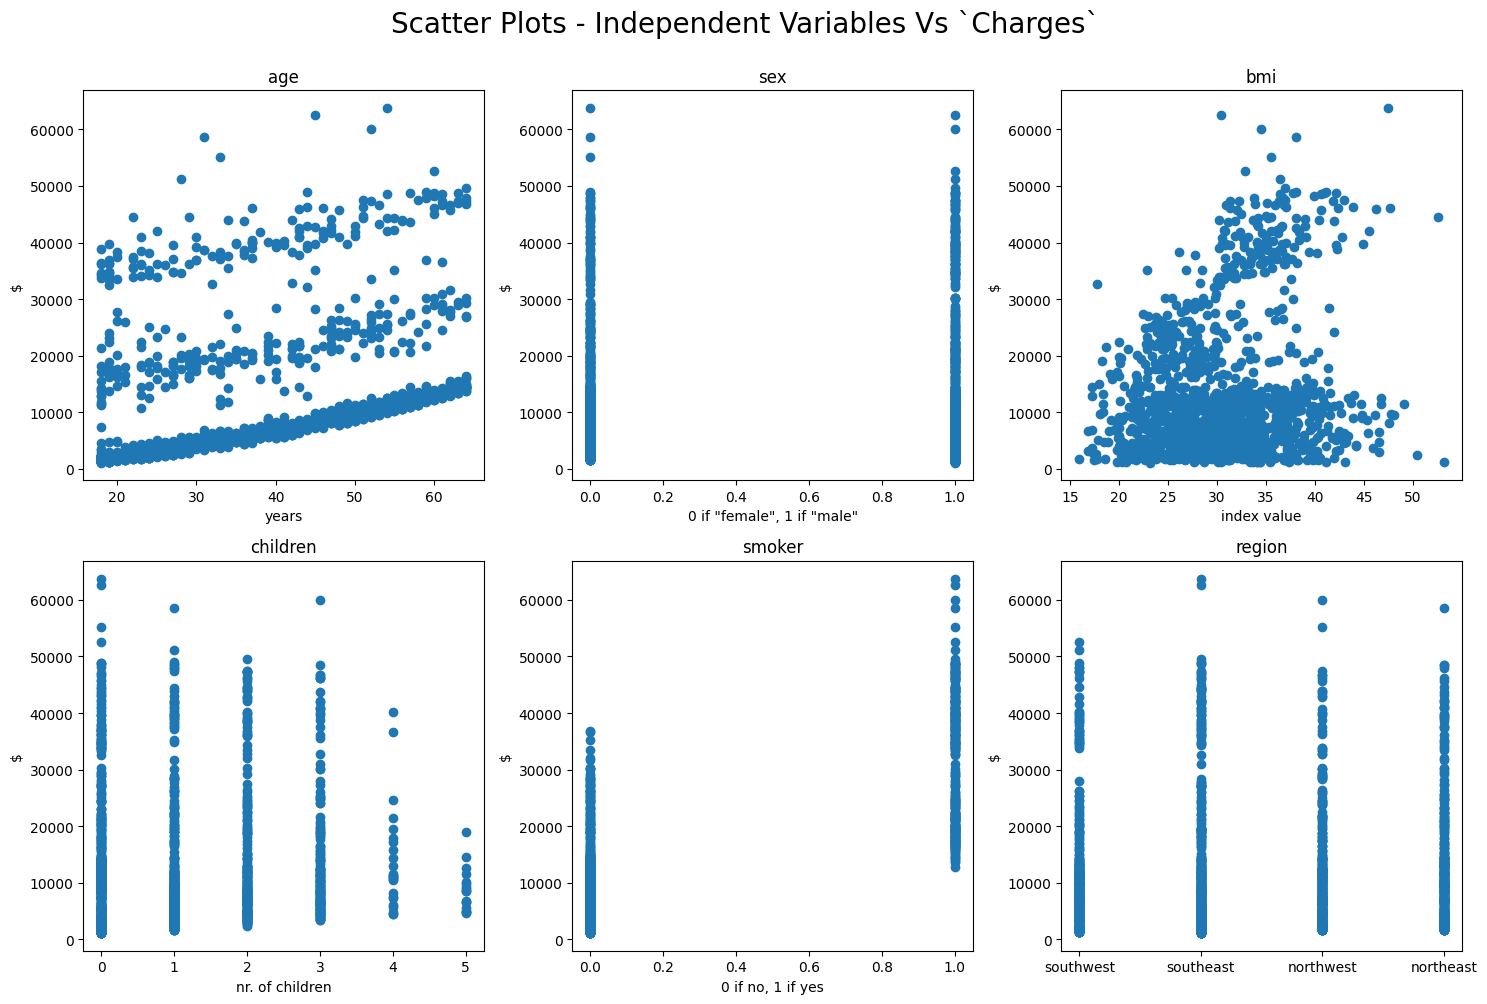

In [55]:
feats = [col for col in ins.columns if col != 'charges']

feats_labels = [
    'years',
    '0 if "female", 1 if "male"',
    'index value',
    'nr. of children',
    '0 if no, 1 if yes',
    ''
    ]

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

plt.suptitle(
    'Scatter Plots - Independent Variables Vs `Charges`',
    size=20,
    y=1
    )

for i in range(0, 5+1):
    if i < 3:
        ax_ = ax[0, i]
    else:
        ax_ = ax[1, i-3]
    
    col = feats[i]
    ax_.scatter(ins[col], ins['charges'])
    ax_.set_title(col)
    ax_.set_xlabel(feats_labels[i])
    ax_.set_ylabel('$')
    
plt.tight_layout()
plt.show()

#### Analysis of scatter plots.

- `age`: seems to have three different positive correlations patterns, which may indicate that within the pool of patients there are three different profiles that we can try to separate using some criterion. 


- `sex`: does not show a great disparity of dispersion between female and male observations, which reinforces the idea that sex and patient insurance expenses are not related.


- `bmi`: at first glance, this predictor seems to have no correlation with `charge`, however, there seems to be a two different patterns: one concentration in the lower region of the graph (roughly from \\$0 to \\$15000), which does not seem to be correlated with `charge`; and a second one that seems to portray an increasing correlation between `bmi` and `charge`, that goes roughly from \\$0 up to \\$50000 (excluding possible outliers). At this stage we'll be including this variable in the model. 


- `children`: doesn't seem highly correlated with `charge`. Patients with 4 and 5 children seem to spend considerably less then the rest of the patients. A social-economic explanation for that phenomenon may exist, but for now we'll exclude this variable from the analysis. 


- `smoker`: this predictor is in line with the idea that smokers pay more for insurance.


- `region`: the dispersion of observations by region does not seem to reveal great disparities among them. We'll reserve this variable for a separate analysis with dummy encoding for each region.

## Splitting Train And Test Data Sets And Building The First Model
---
The train set will have 80% of the original data whilst the test set will have the remaining 20%, setting a pseud-random state at 5. 

In [56]:
train, test = split(ins, random_state=5, test_size=0.2)

### Predictors to be included in the regression.

To start, we'll be using only a very short selection of predictors that showed a substantial correlation with the target: `smoker`, `age`; we also include `sex` just to see what is the magnitude value of the coefficient, even though we know that its correlation with the target variable is weak.

Below we build a function - `reg_results()`, that takes as input: a train and a test data set; the features to be included in the model as predictors; and returns a dictionary containing the following:
- A `statsmodels` OLS (ordinary least squared) object.
- The summary statistics of the fitted regression.
- The mean squared and root mean squared errors, associated to the test predictions.

In [57]:
def reg_results(feats, train, test):
    
    # Fit.
    X_train= train[feats]
    X_train_w_const = sm.add_constant(X_train, prepend=True)
    y_train = train.charges.values.reshape(-1, 1)

    est = sm.OLS(y_train, X_train_w_const.values)
    ols = est.fit()
    
    # Predict.
    X_test = test[feats]
    X_test_w_const = sm.add_constant(X_test, prepend=True)
    y_test = test.charges.values.reshape(-1, 1)

    prediction = ols.predict(X_test_w_const.values)
    
    # Error.
    mse_ = round(mse(y_test, prediction), 2)
    rmse_ = round(np.sqrt(mse_), 2)

    return {
        'ols': est.fit(),
        'summary': ols.summary2(),
        'MSE': mse_,
        'RMSE': rmse_
        }

In [58]:
def result_printer(results):
    for key in results:
        if key != 'ols':
            print(f'{key} = {results[key]}')
    return

We start by using the train set to both train and predict the outcome in order to later compare it with the test set errors.

In [59]:
feats_1 = ['age', 'bmi', 'smoker']

results_1 = reg_results(feats_1, train, train)

result_printer(results_1)

summary =                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.738     
Dependent Variable: y                AIC:                21716.5536
Date:               2023-05-24 10:01 BIC:                21736.4553
No. Observations:   1070             Log-Likelihood:     -10854.   
Df Model:           3                F-statistic:        1004.     
Df Residuals:       1066             Prob (F-statistic): 5.17e-310 
R-squared:          0.739            Scale:              3.8043e+07
-------------------------------------------------------------------
          Coef.     Std.Err.    t     P>|t|     [0.025     0.975]  
-------------------------------------------------------------------
const  -11541.3321 1060.3161 -10.8848 0.0000 -13621.8758 -9460.7884
x1        260.0737   13.6533  19.0484 0.0000    233.2833   286.8642
x2        321.3907   31.0383  10.3546 0.0000    260.4875   382.2939
x3      23621.2286  467.6223  50.5135 0.0000  22703.6639

Commenting on the coefficients values:
- `intercept`: is not directly interpretable; if we were consider it literally, at birth an individual would start with a negative debt of \\$11459.60, which doesn't make any sense. Because the lowest value in the data set is 18 years old, and the person with the minimum BMI in the sample has bmi of 15.96, we can say that regardless of sex, a person with this age and BMI would have a 'charge' of 
$18*259.79 + 15.96*322.63 - 11459.60$ which is equal to $-1634.21$, i.e. 18 (years) times the `age` coefficient, minus the intercept negative 'charge'.

As we can see, the model is not very accurate because it has a prediction of negative values when in fact there is patient that has 18 years of age and the smallest BMI in the sample - 15.96, and dos not smoke, having actual insurance charges:

In [60]:
print('Predicted y:') 
-11541.3321 + 260.0737*18 + 321.3907*15.96 +23621.2286*0

Predicted y:


-1730.6099279999999

In [61]:
ins.query('age == 18 & bmi == 15.96')

,age,sex,bmi,children,smoker,region,charges
172,18,1,15.96,0,0,northeast,1694.7964


Let's exclude `bmi` and check whether we have a positive insurance charge for a 18 year old non-smoker.

In [62]:
feats_2 = ['age', 'smoker']

results_2 = reg_results(feats_2, train, train)

result_printer(results_2)

summary =                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.712     
Dependent Variable: y                AIC:                21817.0997
Date:               2023-05-24 10:01 BIC:                21832.0260
No. Observations:   1070             Log-Likelihood:     -10906.   
Df Model:           2                F-statistic:        1321.     
Df Residuals:       1067             Prob (F-statistic): 1.89e-289 
R-squared:          0.712            Scale:              4.1830e+07
--------------------------------------------------------------------
         Coef.     Std.Err.     t     P>|t|     [0.025      0.975]  
--------------------------------------------------------------------
const  -2352.7369  608.5551  -3.8661  0.0001  -3546.8375  -1158.6363
x1       277.1374   14.2121  19.5001  0.0000    249.2505    305.0243
x2     23634.3908  490.3440  48.1996  0.0000  22672.2428  24596.5389
--------------------------------------------------

Commenting on the rest of the results.

- `intercept`: in this case a non-smoker 18 year old patient will have a minimal insurance charge of $18*277.13 -2352.73  +23634.39*0$ which is a positive cost of \\$$2635.61$, despite of the intercept being negative.


- `age`: a positive relation between aging and insurance increase is acceptable. The magnitude of this value is also acceptable: \\$277.13.


- `sex`: is not significant - p-value = 0.5547, which surpasses the threshold of 0.05 by a lot. The model with this dummy as been omitted but the regression results can be seen in Annex I (`results_age`).


- `smoker`: also shows an expected positive relation with `charge`. The value of the coefficient is of very high magnitude when compared with the others: being a smoker increases the insurance charges around \\$23634.39 It is statistically significant.


**Coefficient validation**: Besides `sex`, both the intercept, `age` and `smoke`, are statistically significant at 1%.

**Mean Squared Error**: The MSE, at this time is not relevant unless we compare it with the test MSE.

**R-squared**: the $R^2$ shows that `age` and `smoker` are good predictors of the target since they account for 71.2% of its variation. Compared with the with the model that includes a significant 'bmi' the $R^2$ is 73.8%, which indicates that this variable is somehow redundant, thus reinforcing the idea that its exclusion as is, is justified.

### Residual Diagnostics

In [63]:
y_hat_train_2 = results_2['ols'].predict(sm.add_constant(train[feats_2]).values)

resids = train['charges'] - y_hat_train_2

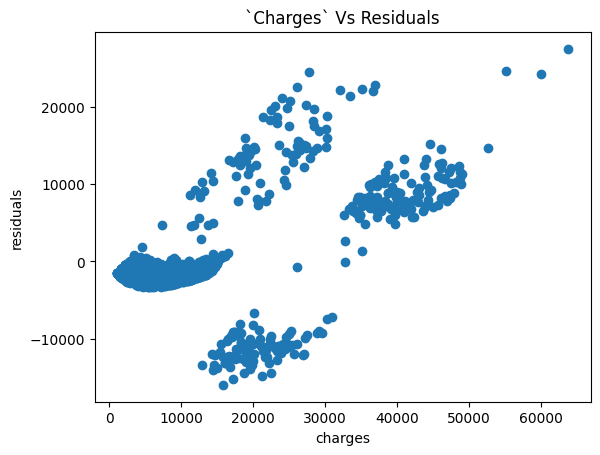

In [64]:
 resids_df = pd.concat(
        {
            'train': resids, 'sample': resids.sample(n=268)
        },
        axis=1
    )

plt.scatter(train['charges'], resids)

plt.ylabel('residuals')
plt.xlabel('charges')

plt.title('`Charges` Vs Residuals')

plt.show()

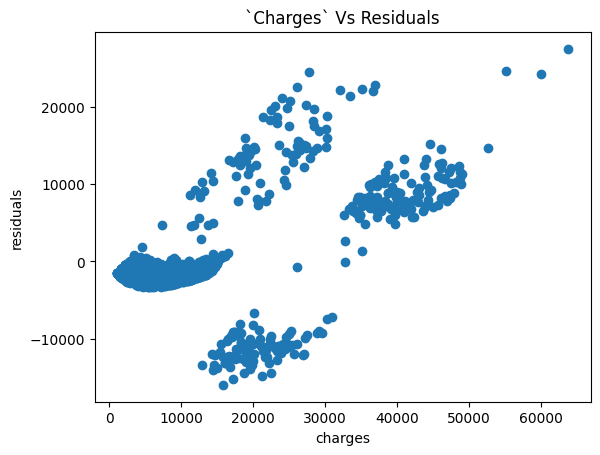

In [65]:
plt.scatter(train['charges'], resids)

plt.ylabel('residuals')
plt.xlabel('charges')

plt.title('`Charges` Vs Residuals')

plt.show()

As we can see in the scatter plot above, the residuals do not appear to be round 0 at a constant variance. 

It seems that are two parallel upward trends where the residuals increase in magnitude as the `charges` increase.

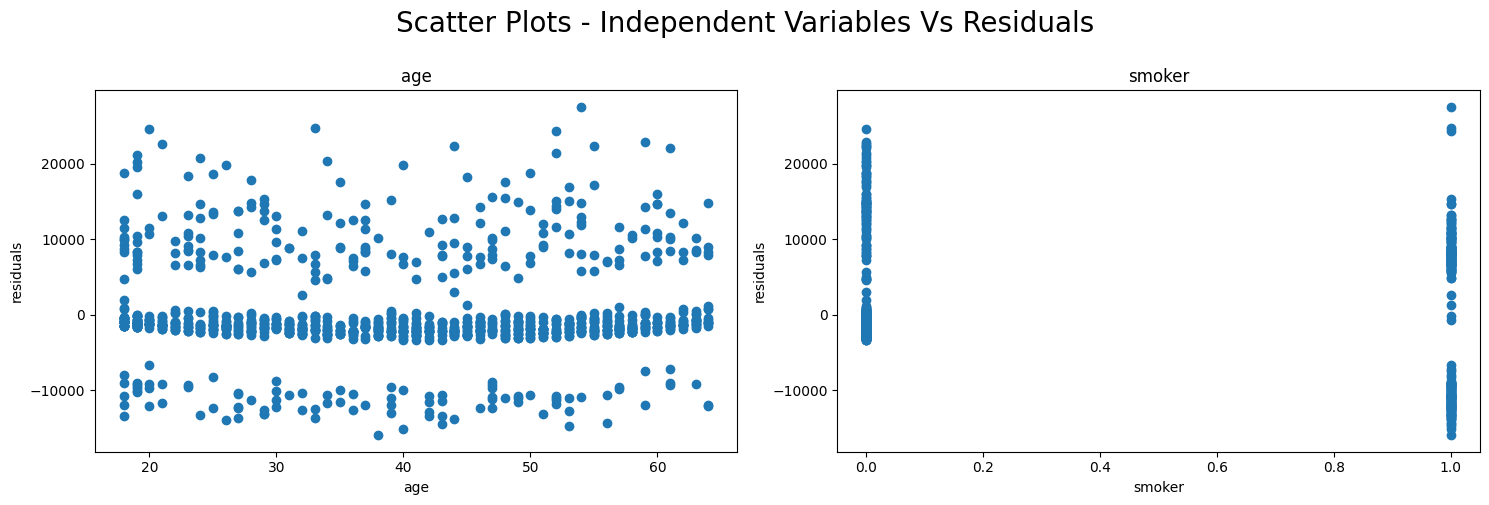

In [66]:
feats0 = ['age', 'smoker']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.suptitle(
    'Scatter Plots - Independent Variables Vs Residuals',
    size=20,
    y=1
    )

for i in range(0, 1+1):
    row0 = ax[i]
    row0.scatter(train[feats0[i]], resids)
    row0.set_title(feats0[i])
    row0.set_xlabel(feats0[i])
    row0.set_ylabel('residuals')
    
plt.tight_layout()
    
plt.show()

When fitting the explanatory variables against the residuals we cannot see a trend for `age`, where the residuals see heavier on the positive side, but at a constant variance. In the other, `smoker` has less extreme residuals when 0 (non-smoker) and more dispersion when 1 (smoker).

## Prediction Error Comparision And Model Evaluation

In [67]:
y_hat_test_2 = results_2['ols'].predict(sm.add_constant(test[feats_2]).values)

mse_test_2 = round(mse(test['charges'], y_hat_test_2), 2)

rmse_train_2 = np.sqrt(results_2['MSE'])
rmse_test_2 = np.sqrt(mse_test_2)

compare = pd.DataFrame(
    {
        'MSE': [results_2['MSE'], mse_test_2],
        'RMSE': [rmse_train_2, rmse_test_2]
    },
    index=['train', 'test']
    ).round(2)

compare

,MSE,RMSE
train,41713204.54,6458.58
test,37366693.21,6112.83


The RMSE of the test predicted values are slightly lower that the train RMSE, therefore we can affirm that this model has some predicting power. 

Let's see the range of the RMSE when compared with the minimum and maximum values in `test['charges']`:

In [68]:
min_error = round(rmse_test_2*100/test['charges'].max(), 2)
max_error = round(rmse_test_2*100/test['charges'].min(), 2)

print(f'Minimum error ratio: {min_error}%')
print(f'Maximum error ratio: {max_error}%')

Minimum error ratio: 9.77%
Maximum error ratio: 537.91%


As we can see, the minimum value that we can find in `test['charges']` is a lot smaller than the respective RMSE - \\$1136.39 and \\$6112.83, respectively. Therefore, we cannot designate the current RMSE as adequate. We surely can produce a model with better predicting capabilities.

In [69]:
test[test.charges==test["charges"].min()]

,age,sex,bmi,children,smoker,region,charges
663,18,1,33.66,0,0,southeast,1136.3994


## Extra Task - Improve The Model By Adding Other Variables Such As Dummies
---
For this task, we'll be adding as explanatory variables, in separate models, dummy variables concerning age intervals and country regions.

### Adding country region.
---
As we seen previously, the `sex` variable is not significant, therefore we can exclude it from the next batteries' of analysis. 

To avoid the 'dummy trap' we'll be omitting the column `notheast` as our default state. 

#### Turning `region` into a set of dummy columns.

In [70]:
regions = dict(zip(sorted(list(ins.region.unique())), [0, 1, 2, 3]))

regions

{'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}

In [71]:
ins['region_cat'] = pd.Categorical(
    ins['region'].map(regions),
    categories=[0, 1, 2, 3],
    ordered=True)

In [72]:
ins[['region', 'region_cat']].head()

,region,region_cat
0,southwest,3
1,southeast,2
2,southeast,2
3,northwest,1
4,northwest,1


In [73]:
region_d = pd.get_dummies(ins.region_cat)
region_d = region_d.rename(
    columns={regions[key]: key for key in regions}
    )

ins = pd.concat([ins, region_d], axis=1)

In [74]:
ins[['northeast', 'northwest', 'southeast',
       'southwest']].head()

,northeast,northwest,southeast,southwest
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0


Split and train again, same random state.

In [75]:
train, test = split(ins, random_state=5, test_size=0.2)

In [76]:
feats_regions = [
    'age', 'smoker', 'northwest', 'southeast','southwest'
                ]

results_regions = reg_results(feats_regions, train, test)


result_printer(results_regions)

summary =                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.712     
Dependent Variable: y                AIC:                21820.2073
Date:               2023-05-24 10:01 BIC:                21850.0598
No. Observations:   1070             Log-Likelihood:     -10904.   
Df Model:           5                F-statistic:        529.1     
Df Residuals:       1064             Prob (F-statistic): 1.63e-285 
R-squared:          0.713            Scale:              4.1835e+07
--------------------------------------------------------------------
         Coef.     Std.Err.     t     P>|t|     [0.025      0.975]  
--------------------------------------------------------------------
const  -2500.3940  701.9641  -3.5620  0.0004  -3877.7853  -1123.0028
x1       277.7923   14.2207  19.5344  0.0000    249.8885    305.6961
x2     23600.8194  491.1895  48.0483  0.0000  22637.0093  24564.6295
x3       226.0910  567.0195   0.3987  0.6902   -88

In the results displayed above, we can see that controlling for regions does not yield significant coefficients, and also does not reduce the prediction error beyond the simpler model (see the table `compare_2` below).

In [77]:
error_regions = [results_regions['MSE'], results_regions['RMSE']]

compare_2 = pd.DataFrame(
    {
        'age, smoker': compare.loc['test', :].values,
        'age, smoker, region dummies': error_regions
    },
    index=['MSE', 'RMSE'])

compare_2

,"age, smoker","age, smoker, region dummies"
MSE,37366693.21,37482822.39
RMSE,6112.83,6122.32


### Analyzing age intervals.

In this section we create and add dummies that allow the model to control for age intervals. The idea is to try to understand if insurance charges are set differently for young, middle age and senior adults.  

In [78]:
ins.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

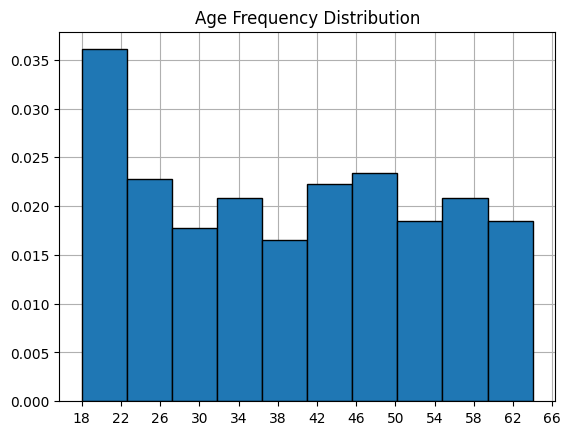

In [79]:
fig, ax = plt.subplots()

ax.hist(ins.age, density=True, edgecolor = "black")
ax.set_title('Age Frequency Distribution')
ax.set_xticks(np.arange(18, 64+4, 4))
ax.grid()
ax.set_axisbelow(True)

plt.show()

According the the age histogram, there is an age interval that is more frequent than the rest, otherwise, all ages are relatively evenly distributed. 

Let's divide the age into three intervals:
- 18 up to 34 (young adults - 6 years range )
- 35 up to 59 middle age - 24 years range)
- 60 up to 64 (seniors - 5 year range)


The function below, `age_intervals()`, appends to `ins` the age related dummy columns, where `young` is the default _status_quo_. 

In [80]:
def age_intervals(df, y_range, m_range, s_range):
    
    young_adult = y_range
    middle = m_range
    seniors = s_range

    modded_age = df.age.replace(young_adult, 'young_adult').replace(middle, 'middle_age').replace(seniors, 'senior')
    
    print(modded_age.value_counts(normalize=True).round(2))
    
    age_dummies = pd.get_dummies(modded_age).rename(
                            columns={1: 'young_adult', 2: 'middle_age', 3:'senior'}
                            ).drop(columns='young_adult')
    
    if 'middle_age' not in df.columns:
        df = pd.concat([df, age_dummies], axis=1)
    
    return df

`age_intervals()` also prints the normalized value counts so that we can have an idea of the distribution of the observations. As we can see below, patients with 60 years or more have a low representation - 9%, whilst the other age intervals are reasonably evenly distributed among themselves.

In [81]:
young_adult = range(18, 34+1)
middle = range(35, 59+1)
seniors = range(60, 64+1)

print('# Frequency distribution `ins`:\n')
ins_age_1 = age_intervals(ins, young_adult, middle, seniors)

print('\n# Frequency distribution `train`:\n')
train = age_intervals(train, young_adult, middle, seniors)

print('\n# Frequency distribution `test`:\n')
test = age_intervals(test, young_adult, middle, seniors)

# Frequency distribution `ins`:

middle_age     0.50
young_adult    0.41
senior         0.09
Name: age, dtype: float64

# Frequency distribution `train`:

middle_age     0.52
young_adult    0.40
senior         0.08
Name: age, dtype: float64

# Frequency distribution `test`:

young_adult    0.46
middle_age     0.44
senior         0.09
Name: age, dtype: float64


Fitting the new model with two dummies - `middle_age` and `senior`; the default _status_quo_ is 'young adult', and replacing `age` by `bmi`.

In [82]:
feats_age = [
    'bmi', 'smoker', 'middle_age', 'senior'
                ]

results_age = reg_results(feats_age, train, test)


result_printer(results_age)

summary =                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.721     
Dependent Variable: y                AIC:                21783.9710
Date:               2023-05-24 10:01 BIC:                21808.8480
No. Observations:   1070             Log-Likelihood:     -10887.   
Df Model:           4                F-statistic:        692.1     
Df Residuals:       1065             Prob (F-statistic): 2.40e-294 
R-squared:          0.722            Scale:              4.0480e+07
-------------------------------------------------------------------
            Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
-------------------------------------------------------------------
const     -5218.2823 1011.2836 -5.1601 0.0000 -7202.6169 -3233.9478
x1          336.3239   31.9649 10.5216 0.0000   273.6024   399.0453
x2        23377.8133  482.4395 48.4575 0.0000 22431.1734 24324.4532
x3         5169.3768  411.7224 12.5555 0.0000  4361.4976

As we can see below, adding age intervals as parameters do not add relevant predicting power to the model even though they appear to be significant for a 5% threshold.


In [83]:
error_age = pd.Series(
    [results_age['MSE'], results_age['RMSE']],
    index=['MSE', 'RMSE'], name='bmi, smoker, age dummies')

compare_3 = pd.concat([compare_2, error_age], axis=1)

compare_3

,"age, smoker","age, smoker, region dummies","bmi, smoker, age dummies"
MSE,37366693.21,37482822.39,37266914.51
RMSE,6112.83,6122.32,6104.66


### Looking for other structural patterns in the data set.

Since we were not able to find any significant relationships between both regions and age intervals in relation to insurance charges we finish the analysis analysis with a section that tries to find what is the factor that creates the three patterns we can see in the scatter plot that observes `age` vs `charges`: as we can see (below), there is base that seems to have a increasing trend, and than two other lines above it. If we were able to find a model that could control for this pattern, it would render better predictions.

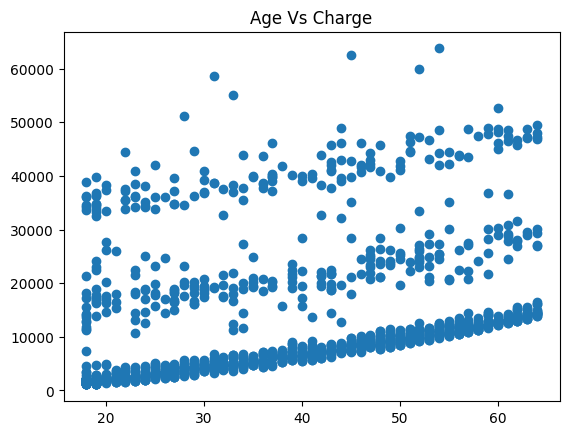

In [84]:
plt.scatter(ins.age, ins.charges)

plt.title('Age Vs Charge')

plt.show()

As we can see in the scatter plot below, controlling for 'smoker/non-smoker' shows those two trends above the base line.

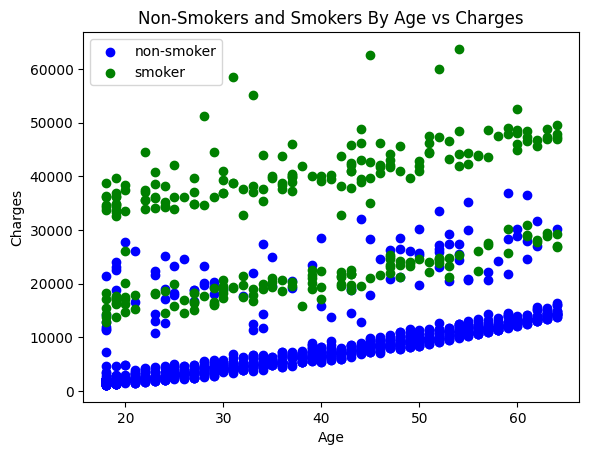

In [85]:
plt.scatter(ins.query('smoker == 0').age,
            ins.query('smoker == 0').charges,
            color='blue',
            label='non-smoker')

plt.scatter(ins.query('smoker == 1').age,
            ins.query('smoker == 1').charges,
            color='green',
            label='smoker')

plt.legend(loc=2)

plt.xlabel('Age')
plt.ylabel('Charges')

plt.title('Non-Smokers and Smokers By Age vs Charges')

plt.show()

Creating filter that signals patients that are male, obese and smoke, shows that the upper trend can be distinguished from the others two below. Although omitted, controlling also for sex, i.e. sex, smoker, BMI, does not yield gender differences.

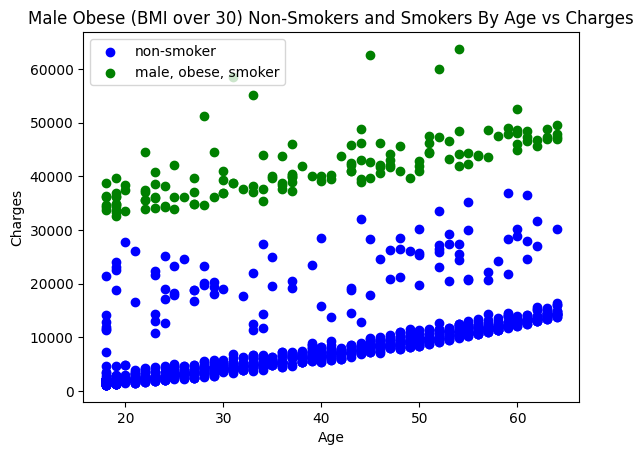

In [86]:
plt.scatter(ins.query('smoker == 0').age,
            ins.query('smoker == 0').charges,
            color='blue',
            label='non-smoker')

plt.scatter(ins.query('smoker == 1 & bmi > 30').age,
            ins.query('smoker == 1 & bmi > 30').charges,
            color='green',
            label='male, obese, smoker')

plt.legend(loc=2)

plt.xlabel('Age')
plt.ylabel('Charges')

plt.title('Male Obese (BMI over 30) Non-Smokers and Smokers By Age vs Charges')

plt.show()

If we control for BMI for smoker vs non-smoker, we can also see that obese smokers are paying mode charges.

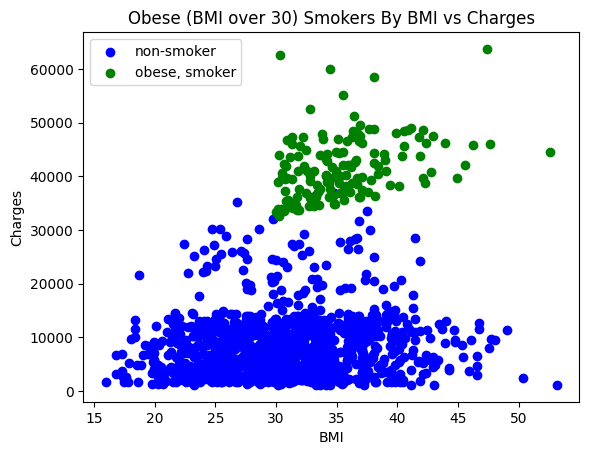

In [87]:
plt.scatter(ins.query('smoker == 0').bmi,
            ins.query('smoker == 0').charges,
            color='blue',
            label='non-smoker')

plt.scatter(ins.query('smoker == 1 & bmi > 30').bmi,
            ins.query('smoker == 1 & bmi > 30').charges,
            color='green',
            label='obese, smoker')

plt.scatter(ins.query('smoker == 0 & bmi > 30').bmi,
            ins.query('smoker == 0 & bmi > 30').charges,
            color='orange',
            label='obese, non-smoker')

plt.legend(loc=2)

plt.xlabel('BMI')
plt.ylabel('Charges')

plt.title('Obese (BMI over 30) Smokers By BMI vs Charges')

plt.show()

### 'Dummyfying' BMI into not-obese/obese.

In [88]:
ins['obese'] = ins.bmi.apply(lambda x: 0 if x < 30 else 1)

train, test = split(ins, random_state=5, test_size=0.2)

In [89]:
feats_obese_1 = ['age', 'smoker', 'obese']

results_obese_1 = reg_results(feats_obese_1, train, test)

result_printer(results_obese_1)

summary =                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.741     
Dependent Variable: y                AIC:                21705.6462
Date:               2023-05-24 10:01 BIC:                21725.5479
No. Observations:   1070             Log-Likelihood:     -10849.   
Df Model:           3                F-statistic:        1018.     
Df Residuals:       1066             Prob (F-statistic): 2.26e-312 
R-squared:          0.741            Scale:              3.7657e+07
--------------------------------------------------------------------
         Coef.     Std.Err.     t     P>|t|     [0.025      0.975]  
--------------------------------------------------------------------
const  -3949.2101  595.6251  -6.6304  0.0000  -5117.9407  -2780.4794
x1       261.9359   13.5563  19.3221  0.0000    235.3359    288.5360
x2     23594.6460  465.2575  50.7131  0.0000  22681.7216  24507.5705
x3      4128.7694  378.1038  10.9197  0.0000   338

#### Error comparison with previous models. 

In [90]:
error_obese = pd.Series(
    [results_obese_1['MSE'], results_obese_1['RMSE']],
    index=['MSE', 'RMSE'],
    name='age, smoker, obese'
    )

compare_4 = pd.concat([compare_3, error_obese], axis=1)

compare_4

,"age, smoker","age, smoker, region dummies","bmi, smoker, age dummies","age, smoker, obese"
MSE,37366693.21,37482822.39,37266914.51,32420904.00
RMSE,6112.83,6122.32,6104.66,5693.94


As we can see, there is an improvement in the model when we control for obesity: obese patients (BMI over 30) will spend on average more 
\\$4128.76 than non obese patients. 

In terms of variation explanation, this model has more power than the previous:
- $R^2_{\text{age, smoker}} = 0.712$ 
- $R^2_{\text{age, smoker, obese}} = 0.741$  

We can also see that the patient with the minimum age of 18 years cannot have negative charges:

$(18 * 261.9359) - 3949.2101 = 765.6361$ USD

In terms of predicting power, we can see that the new model shows a lower MSE and RMSE when compared with the previous.

## Conclusion
---
With this project we've found out that the explanatory variables from the original data set that best help to predict the medical insurances charges were `age`, `smoker` and `obese`: that is, the older a person becomes, the more it pays in charges; smokers and obese people also pay more in insurance charges than their counter parts. On the other hand, we saw that controlling for genre, region, and even age intervals, did not help to come up with a better model, since these variables were not significant neither resulted in better predictions. In terms of improvements that can be achieved, if the data had columns that gathered a few socio-economical aspects of the patients it would certainly contribute to predict insurance charges more accurately. In these socio-economical features we can include the type of job the patient has, e.g. distinguishing between desk jobs from 'hard labor' jobs, monthly income, level of education, etc. These aspects are important because they help to shape the behaviors that can possibly affect the health of any individual, and also help to control for the exposure to health hazards, which definitely have implications in the number of visits to health centers, and insurance expenditures.

## Annex I
---

Regressions results with the `sex` dummy (prediction of the train set):

In [91]:
feats_sex = ['age', 'sex', 'bmi', 'smoker']

results_sex = reg_results(feats_sex, train, train)

result_printer(results_sex)

summary =                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.738     
Dependent Variable: y                AIC:                21718.2028
Date:               2023-05-24 10:01 BIC:                21743.0799
No. Observations:   1070             Log-Likelihood:     -10854.   
Df Model:           4                F-statistic:        752.9     
Df Residuals:       1065             Prob (F-statistic): 1.50e-308 
R-squared:          0.739            Scale:              3.8067e+07
-------------------------------------------------------------------
          Coef.     Std.Err.    t     P>|t|     [0.025     0.975]  
-------------------------------------------------------------------
const  -11459.6004 1069.6192 -10.7137 0.0000 -13558.4008 -9360.8000
x1        259.7988   13.6654  19.0114 0.0000    232.9846   286.6131
x2       -224.1687  379.3341  -0.5910 0.5547   -968.4958   520.1585
x3        322.6375   31.1194  10.3677 0.0000    261.5751